# Get Data

### import modules

In [1]:
from nilearn import image, datasets, input_data, plotting

import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

### download data

In [2]:
#%%bash
#
#wget https://www.nitrc.org/frs/download.php/9322/lx.zip -O ../test.zip

In [3]:
#%%bash
#tar -xzvf ../test.tar.gz -C ../

### extracting data from certain coordinates

In [4]:
exampleSeeds = [(-48,-50,4),(-30,-40,66),(0,10,10)]

In [5]:
seedMaskerRaw = input_data.NiftiSpheresMasker(exampleSeeds,radius=5,
                                              standardize=False,detrend=False).fit()

In [6]:
seedMaskerStd = input_data.NiftiSpheresMasker(exampleSeeds,radius=5,
                                              standardize=True,detrend=True).fit()

### extracting voxel-wise data

In [7]:
brainMaskerRaw = input_data.NiftiMasker(mask_img='../masks/MNI152_T1_2mm_brain_mask.nii.gz',
                                        standardize=False,detrend=False).fit()

In [8]:
brainMaskerStd = input_data.NiftiMasker(mask_img='../masks/MNI152_T1_2mm_brain_mask.nii.gz',
                                        standardize=True,detrend=True).fit()

### use masker to get data from run

In [9]:
def getData(i,masker,conf=True):
    # get fmri run
    epi = '../data/wrrun00%s.nii.gz'%i
    #get movement parameters
    movement = '../data/rp_run00%s.txt'%i
    
    # extract data
    if conf:
        data=masker.transform(epi,confounds=movement)
    else:
        data=masker.transform(epi)
        
    # put into dataframe
    dataDf = pd.DataFrame(data)
    #get design file
    designDf = pd.read_csv('../data/run%s.csv'%i)
    designDf['TR'] = range(0,241,10)
    return dataDf,designDf

Example:

In [10]:
dataDf,designDf = getData(1,seedMaskerRaw,conf=False)

In [11]:
dataDf

,0,1,2
0,750.827160,912.814815,1026.493827
1,747.950617,908.271605,1026.407407
2,751.987654,911.123457,1026.790123
3,745.481481,908.111111,1008.679012
4,738.432099,915.641975,1024.740741
5,739.012346,910.592593,1026.913580
6,738.592593,907.074074,1015.246914
7,740.185185,907.950617,1002.024691
8,747.259259,911.580247,1030.469136
9,738.814815,912.024691,1023.913580


In [12]:
designDf

,condition,content,TR
0,rest,rest,0
1,language,animals,10
2,spatial,citysquare,20
3,faces,family,30
4,motor,badminton,40
5,language,tools,50
6,faces,friends,60
7,spatial,market,70
8,rest,rest,80
9,motor,tennis,90


### assign correct volumes to each condition

In [28]:
def reshapeDesign(designDf,start):
    
    nums = [('00%s_'%(x+start))[-4:] for x in designDf.index]
    designDf['names'] = designDf['condition']+'_'+nums+designDf['content']

    trDf = pd.DataFrame()
    for j in designDf.index:
        thisDf = pd.DataFrame( np.array([designDf.loc[j]]*10) )
        thisDf.columns = designDf.columns
        trDf = trDf.append(thisDf)
        
    # shift by two TR (account for HRF-delay of ca. 6 seconds)
    trDf.index = range(2,trDf.shape[0]+2)
    
    return trDf

In [29]:
trDf = reshapeDesign(designDf,1)

In [30]:
trDf

,condition,content,TR,names
2,faces,movieactors,0,faces_001_movieactors
3,faces,movieactors,0,faces_001_movieactors
4,faces,movieactors,0,faces_001_movieactors
5,faces,movieactors,0,faces_001_movieactors
6,faces,movieactors,0,faces_001_movieactors
7,faces,movieactors,0,faces_001_movieactors
8,faces,movieactors,0,faces_001_movieactors
9,faces,movieactors,0,faces_001_movieactors
10,faces,movieactors,0,faces_001_movieactors
11,faces,movieactors,0,faces_001_movieactors


In [31]:
def makeBlocks(trDf,dataDf):
    blockDf = pd.concat([trDf,dataDf],axis=1)
    blockDf.index = [blockDf['names'],blockDf.index]
    meanBlockDf = blockDf.groupby(level=0).mean()
    return blockDf,meanBlockDf

Example:

In [32]:
blockDf,meanBlockDf = makeBlocks(trDf,dataDf)

In [33]:
blockDf.tail(10)

condition   content   TR               names         0  \
names                                                                           
motor_025_climbing 243     motor  climbing  240  motor_025_climbing -0.652949   
                   244     motor  climbing  240  motor_025_climbing -0.358741   
                   245     motor  climbing  240  motor_025_climbing  0.228444   
                   246     motor  climbing  240  motor_025_climbing  1.763544   
                   247     motor  climbing  240  motor_025_climbing  0.791109   
                   248     motor  climbing  240  motor_025_climbing  0.343596   
                   249     motor  climbing  240  motor_025_climbing  1.160595   
                   250     motor  climbing  240  motor_025_climbing -0.716083   
                   251     motor  climbing  240  motor_025_climbing  1.620038   
NaN                252       NaN       NaN  NaN                 NaN -1.918731   

                               1         2         3         4         5  \
names                                                                      
motor_025_climbing 243 -0.792175  1.541549 -0.185887 -0.070417  0.603667   
                   244 -0.109813 -0.470812 -1.607614 -1.277114 -1.744525   
                   245  0.864127  0.018171 -0.733258  0.330629 -0.619621   
                   246  1.452111 -0.178537 -1.068946  0.278704 -0.733916   
                   247  1.445686  1.607930 -0.806026  0.420036 -1.630013   
                   248  0.928278 -0.443176 -0.301911  0.429630 -0.112984   
                   249  0.849415  0.134364  2.270151  1.984746  1.830935   
                   250 -0.736057  0.618660  0.735639 -0.057877  0.375826   
                   251  1.738726  1.034989 -0.085953  1.202217 -0.758748   
NaN                252 -1.769441 -0.930670 -0.183787 -1.230663 -0.438087   

                          ...       228473    228474    228475    228476  \
names                     ...                                              
motor_025_climbing 243    ...    -0.518669 -1.415975 -1.068674 -0.979155   
                   244    ...     0.233550  0.440955  0.676995  0.594509   
                   245    ...     0.119427 -0.618845 -0.720146 -0.933693   
                   246    ...     0.052702 -0.454154 -0.198510 -0.107299   
                   247    ...    -0.202899 -0.437632 -0.635894 -0.547172   
                   248    ...     0.461142  0.234351 -0.101027  0.429700   
                   249    ...    -0.295877 -0.523287 -0.852127 -0.790357   
                   250    ...     0.154456  0.044913 -0.597280 -0.883016   
                   251    ...     0.293278  0.049391 -0.747011 -0.749083   
NaN                252    ...     0.107425 -0.200663  1.839518  1.771603   

                          228477    228478    228479    228480    228481  \
names                                                                      
motor_025_climbing 243 -0.798169 -0.000830 -1.096093 -1.097386 -0.931717   
                   244  0.806273  0.152116  0.301519  0.493066  0.829638   
                   245 -0.553914  0.660109 -1.114435 -1.084280 -1.952832   
                   246  0.151524  0.182717  0.180023  0.114746 -0.957375   
                   247 -0.805900 -0.356206 -0.645768 -0.336085  0.296756   
                   248  0.673512  1.108572 -0.229014 -0.017774  0.529959   
                   249 -0.759343 -0.127776 -0.934099 -0.918540 -1.756750   
                   250 -0.284176  1.262285 -0.968744 -0.994535 -0.629113   
                   251 -0.214759  1.173518 -0.449566 -0.520535  0.481555   
NaN                252  1.411754 -0.180732  1.875566  1.712020  1.078526   

                          228482  
names                             
motor_025_climbing 243  0.598297  
                   244 -0.556827  
                   245 -0.737292  
                   246  0.996979  
                   247 -0.589421  
                   248 -0.853219  
                   249  0.13416

In [34]:
meanBlockDf.tail(10)

,0,1,2,3,4,5,6,7,8,9,...,228473,228474,228475,228476,228477,228478,228479,228480,228481,228482
names,,,,,,,,,,,,,,,,,,,,,
rest_003_rest,0.015891,0.052901,0.777762,-0.200258,0.053595,0.218498,-0.152897,-0.049758,0.414006,0.168699,...,0.209064,0.145952,-0.113332,-0.101535,-0.187129,-0.286643,-0.069354,-0.065525,-0.373850,0.093498
rest_007_rest,0.121513,0.012093,-0.098347,-0.005989,-0.025589,0.117540,-0.068429,0.238471,-0.364422,0.028950,...,0.270068,0.355701,-0.129602,-0.130629,-0.271762,-0.284465,-0.108177,-0.113235,-0.238478,0.000882
rest_011_rest,-0.430323,-0.414166,0.589220,0.015175,-0.094907,0.169843,0.123146,0.281146,0.103334,-0.506455,...,0.637157,0.346669,-0.144808,-0.122169,-0.029432,0.144572,-0.146181,-0.156524,-0.793961,0.153402
rest_019_rest,-0.141693,-0.184043,0.999644,0.344312,0.323878,0.537584,0.405651,0.619002,0.410616,0.283396,...,-0.299332,0.022418,-0.078889,-0.070500,-0.180388,-0.153149,-0.082980,-0.109885,0.008321,-0.144322
rest_022_rest,0.177211,0.054052,0.348560,0.914852,0.648050,0.758258,0.795658,0.596187,-0.164432,-0.386059,...,0.081657,0.412192,0.057087,0.080710,0.038836,-0.049545,0.123328,0.041223,0.541392,0.228019
spatial_004_market,-0.384518,-0.010347,-0.656230,-0.432311,-0.371830,-0.508818,-0.346090,-0.627226,0.237245,-0.464828,...,-0.395495,-0.583872,0.077671,0.051366,0.023334,-0.096044,-0.146119,-0.024469,-0.388396,-0.799966
spatial_009_school,0.334278,0.330364,-0.496889,-0.122829,0.045441,-0.359327,-0.207962,0.010495,-0.147101,0.222231,...,-0.178544,-0.194885,0.428024,0.455749,0.189578,-0.262771,0.491997,0.460271,0.640438,0.460623
spatial_013_citysquare,0.624635,0.372718,0.054091,0.447432,0.561659,0.446998,0.323774,0.217018,0.604710,-0.478517,...,1.075133,0.898929,0.216236,0.264525,0.400247,0.349108,0.271869,0.265594,-0.432927,0.067378
spatial_018_market,0.315290,0.428699,0.336721,-0.732507,-0.158673,-0.513495,-0.798125,-0.725969,0.115121,-0.828371,...,-0.254986,-0.079446,0.287046,0.357186,0.500638,0.494522,0.374054,0.348947,0.267532,0.341042


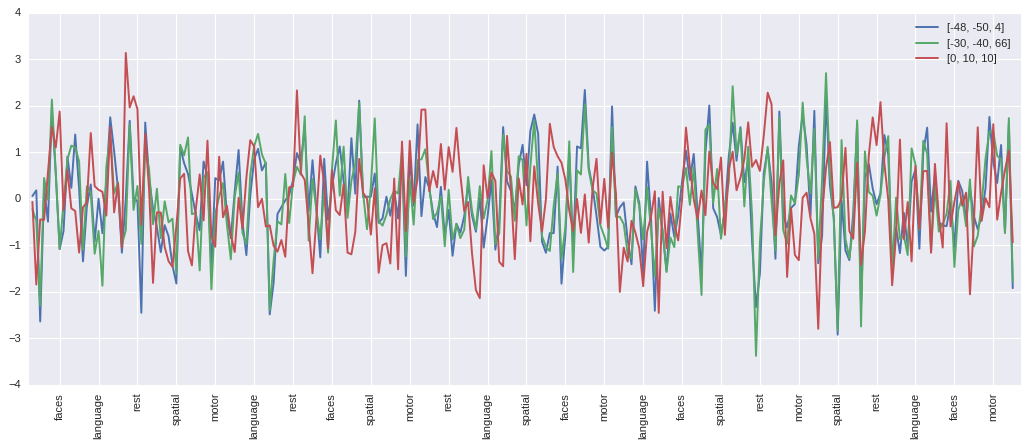

In [35]:
fig,ax = plt.subplots(1,1,figsize=(16,6))
for i,seed in enumerate(seedMaskerRaw.seeds_):
    plt.plot( blockDf[i].values,label=seed)
plt.xlim(-1,blockDf.shape[0]+1)

xConds = blockDf['condition'].dropna()
plt.xticks(np.arange(2,xConds.shape[0]+2)[5::10],xConds[5::10],rotation=90)
sns.despine()

plt.legend(loc='best')

plt.show()

### with standardization

In [36]:
dataDf,designDf = getData(1,seedMaskerStd,conf=False)
trDf = reshapeDesign(designDf,1)
blockDf,meanBlockDf = makeBlocks(trDf,dataDf)

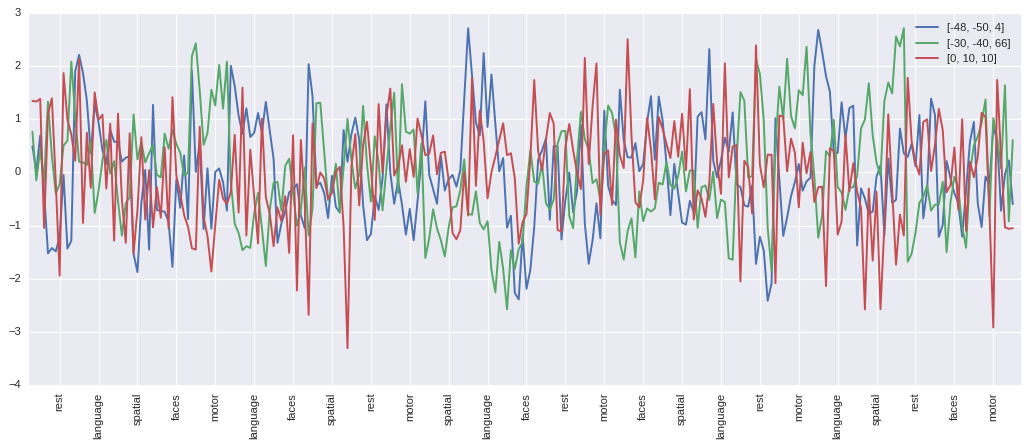

In [37]:
fig,ax = plt.subplots(1,1,figsize=(16,6))
for i,seed in enumerate(seedMaskerStd.seeds_):
    plt.plot( blockDf[i].values,label=seed)
plt.xlim(-1,blockDf.shape[0]+1)

xConds = blockDf['condition'].dropna()
plt.xticks(np.arange(2,xConds.shape[0]+2)[5::10],xConds[5::10],rotation=90)
sns.despine()

plt.legend(loc='best')

plt.show()

In [38]:
def reshapeThis(df):
    
    trDf = pd.DataFrame()
    for j in df.index:
        thisDf = pd.DataFrame( np.array([df.loc[j]]*10) )
        thisDf.columns = df.columns
        trDf = trDf.append(thisDf)
        
    # shift by two TR (account for HRF-delay of ca. 6 seconds)
    trDf.index = range(2,trDf.shape[0]+2)
    
    return trDf

In [39]:
meanTrBlockDf=blockDf.groupby('TR').mean()
meanTrDf = reshapeThis(meanTrBlockDf)

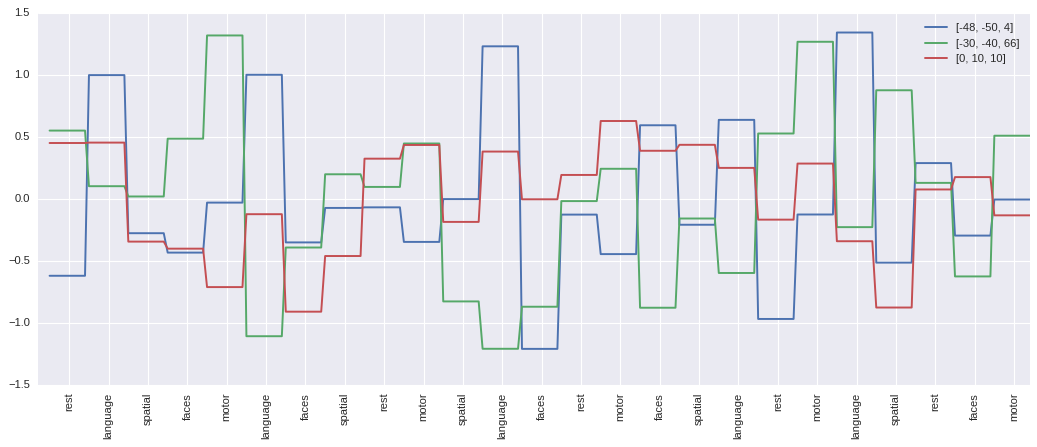

In [40]:
fig,ax = plt.subplots(1,1,figsize=(16,6))
for i,seed in enumerate(seedMaskerStd.seeds_):
    plt.plot( meanTrDf.index,meanTrDf[i].values,label=seed)
plt.xlim(-1,meanTrDf.shape[0]+1)
plt.legend(loc='best')

xConds = blockDf['condition'].dropna()
plt.xticks(np.arange(2,xConds.shape[0]+2)[5::10],xConds[5::10],rotation=90)
sns.despine()

plt.legend(loc='best')

plt.show()

### save all whole-brain data block-wise

In [41]:
bigBlockDf = pd.DataFrame()
for i,j in zip([1,2,3],[1,26,51]):
      
    dataDf,designDf = getData(i,brainMaskerStd,conf=True)
    trDf = reshapeDesign(designDf,j)
    blockDf,meanBlockDf = makeBlocks(trDf,dataDf)
  
    meanBlockDf.index = [['run00%s'%i]*meanBlockDf.shape[0],meanBlockDf.index]
    bigBlockDf = pd.concat([bigBlockDf,meanBlockDf])

In [42]:
bigBlockDf

0         1         2         3       \
       names                                                              
run001 faces_004_family         -0.337221 -0.261674 -0.447705 -0.463183   
       faces_007_friends         0.406736  0.427125  0.015802  0.134407   
       faces_013_movieactors    -0.803729 -0.765207  0.315829 -0.335106   
       faces_016_athletes        0.416349  0.372681  0.368322  0.256957   
       faces_024_tvactors        0.130858 -0.027075 -0.214070  0.041683   
       language_002_animals      0.377199  0.371269  0.208753  0.294844   
       language_006_tools        0.079687  0.169097 -0.180427 -0.336351   
       language_012_cities      -0.241019 -0.297598  0.307364  0.160643   
       language_018_countries   -0.154996 -0.147946 -0.474708 -0.483925   
       language_021_occupations  0.085977 -0.023571  0.044882  0.334655   
       motor_005_badminton       0.232851  0.211707  0.175249 -0.179907   
       motor_010_tennis          0.323449  0.174717 -0.318922  0.865977   
       motor_015_swimming       -0.410231 -0.373177 -0.214435 -0.214162   
       motor_020_soccer         -0.365402 -0.422123 -0.290296 -0.161451   
       motor_025_highjump        0.032260  0.165307 -0.162336 -0.339263   
       rest_001_rest             0.383816  0.345413 -0.421839  0.204600   
       rest_009_rest             0.210772  0.154903  0.267624  0.232909   
       rest_014_rest            -0.099611 -0.071073  0.516288  0.742223   
       rest_019_rest            -0.369821 -0.354001  0.156842  0.201624   
       rest_023_rest             0.800571  0.898288  0.118228  0.316837   
       spatial_003_citysquare   -0.409870 -0.343361  0.178760 -0.154857   
       spatial_008_market       -0.525955 -0.532538  0.320622 -0.216594   
       spatial_011_tramstation   0.027584  0.157118 -0.403917 -0.314847   
       spatial_017_trainstation -0.056431 -0.060108  0.103397 -0.234649   
       spatial_022_school        0.081708  0.126733  0.112864 -0.253421   
run002 faces_029_politicians     0.344705  0.118515 -0.089767  0.536890   
       faces_033_lectureres      0.278460  0.138843 -0.074483 -0.319463   
       faces_036_teachers       -0.436396 -0.250727  0.840851 -0.930371   
       faces_042_family          0.008166  0.106999  0.300277  0.359707   
       faces_047_friends        -0.133380 -0.201361  0.026851 -0.025188   
...                                   ...       ...       ...       ...   
       spatial_026_church        0.730507  0.578703  0.119718  1.370857   
       spatial_032_basement     -0.083324 -0.182674 -0.455861 -0.145466   
       spatial_038_promenade     0.174782  0.180183 -0.170454  0.051832   
       spatial_041_cityofkiel   -0.716268 -0.597343  0.383187 -0.751187   
       spatial_049_univesity    -0.095154 -0.263741 -0.714585  0.450920   
run003 faces_051_movieactors     0.035837  0.277597  0.414609  0.219754   
       faces_058_athletes        0.203997  0.147367 -0.260475 -0.230707   
       faces_064_family         -0.239555 -0.282957  0.317728  0.033827   
       faces_067_friends        -0.129945 -0.308557 -0.050691  0.233076   
       faces_074_politicians    -0.186277 -0.274415 -0.137317  0.144366   
       language_052_countries    0.057899 -0.142724  0.153769  0.254730   
       language_056_animals      0.041745  0.128881 -0.023491 -0.308807   
       language_062_animals     -0.176314  0.011080 -0.642809  0.312212   
       language_066_tools       -0.573870 -0.605712 -0.990530 -0.391563   
       language_073_fruit       -0.089872 -0.056241 -0.167115 -0.293949   
       motor_055_badminton      -0.074365 -0.452001 -0.113353  0.067093   
       motor_060_swimming        0.112817  0.274512  0.353906 -0.199740   
       motor_065_badminton       0.118147  0.130686 -0.134266  0.515010   
       motor_070_tennis          0.626708  0.519312 -0.423559 -0.076280   
       motor_075_climbing        0.381093  0.461640  0.332153 -0.286576   
       rest_053_rest             0.015891  0.052901  0.77776

In [28]:
def makeFiles(bigBlockDf,masker):
    # for the training run (all except run003)
    for i in bigBlockDf.drop('run003').index:
        thisIm = masker.inverse_transform(bigBlockDf.loc[i])
        thisName = '../train/%s.nii.gz'%i[-1]
        print 'writing %s to file...'%thisName
        thisIm.to_filename(thisName)
    # for the test run (dropping 1&2, leaving 3)
    for i in bigBlockDf.drop(['run001','run002']).index:
        thisIm = masker.inverse_transform(bigBlockDf.loc[i])
        thisName = '../test/%s.nii.gz'%i[-1]
        print 'writing %s to file...'%thisName
        thisIm.to_filename(thisName)
    return

In [29]:
makeFiles(bigBlockDf,brainMaskerStd)

writing ../train/faces_004_family.nii.gz to file...
writing ../train/faces_007_friends.nii.gz to file...
writing ../train/faces_013_movieactors.nii.gz to file...
writing ../train/faces_016_athletes.nii.gz to file...
writing ../train/faces_024_tvactors.nii.gz to file...
writing ../train/language_002_animals.nii.gz to file...
writing ../train/language_006_tools.nii.gz to file...
writing ../train/language_012_cities.nii.gz to file...
writing ../train/language_018_countries.nii.gz to file...
writing ../train/language_021_occupations.nii.gz to file...
writing ../train/motor_005_badminton.nii.gz to file...
writing ../train/motor_010_tennis.nii.gz to file...
writing ../train/motor_015_swimming.nii.gz to file...
writing ../train/motor_020_soccer.nii.gz to file...
writing ../train/motor_025_highjump.nii.gz to file...
writing ../train/rest_001_rest.nii.gz to file...
writing ../train/rest_009_rest.nii.gz to file...
writing ../train/rest_014_rest.nii.gz to file...
writing ../train/rest_019_rest.ni

### get secret run

In [30]:
def getSecretData(i,masker,conf=True):
    # get fmri run
    epi = '../data/wrrun00%s.nii.gz'%i
    #get movement parameters
    movement = '../data/rp_run00%s.txt'%i
    
    # extract data
    if conf:
        data=masker.transform(epi,confounds=movement)
    else:
        data=masker.transform(epi)
        
    # put into dataframe
    dataDf = pd.DataFrame(data)
    #get design file
    designDf = pd.read_csv('../data/run%s.csv'%i)
    print data.shape[0]
    print range(0,data.shape[0]-10,10)
    designDf['TR'] = range(0,data.shape[0]-10,10)
    return dataDf,designDf

In [31]:
dataDf,designDf = getSecretData(0,brainMaskerStd,conf=True)
trDf = reshapeDesign(designDf,0)
blockDf,meanBlockDf = makeBlocks(trDf,dataDf)

23
[0, 10]


In [32]:
for i in meanBlockDf.index:
    thisIm = brainMaskerStd.inverse_transform(meanBlockDf.loc[i])
    thisName = '../outofsample/%s.nii.gz'%i
    print 'writing %s to file...'%thisName
    thisIm.to_filename(thisName)

writing ../outofsample/rest_000_rest.nii.gz to file...
writing ../outofsample/secret_001_secret.nii.gz to file...


### store smoothed data

In [43]:
smooMasker = input_data.NiftiMasker(mask_img='../masks/MNI152_T1_2mm_brain_mask.nii.gz',
                                    smoothing_fwhm=8).fit()

In [44]:
trainList = ['../train/%s'%x for x in os.listdir('../train/') ]
testList = ['../test/%s'%x for x in os.listdir('../test/') ]
secretList = ['../outofsample/%s'%x for x in os.listdir('../outofsample/') ]

bigList = trainList+testList+secretList

In [45]:
bigList

['../train/motor_005_badminton.nii.gz',
 '../train/faces_004_family.nii.gz',
 '../train/faces_007_friends.nii.gz',
 '../train/faces_013_movieactors.nii.gz',
 '../train/faces_016_athletes.nii.gz',
 '../train/faces_024_tvactors.nii.gz',
 '../train/faces_029_politicians.nii.gz',
 '../train/faces_033_lectureres.nii.gz',
 '../train/faces_036_teachers.nii.gz',
 '../train/faces_042_family.nii.gz',
 '../train/faces_047_friends.nii.gz',
 '../train/language_002_animals.nii.gz',
 '../train/language_006_tools.nii.gz',
 '../train/language_012_cities.nii.gz',
 '../train/language_018_countries.nii.gz',
 '../train/language_021_occupations.nii.gz',
 '../train/language_028_fruits.nii.gz',
 '../train/language_034_clothing.nii.gz',
 '../train/language_039_vegetables.nii.gz',
 '../train/language_044_furniture.nii.gz',
 '../train/language_048_colors.nii.gz',
 '../train/motor_010_tennis.nii.gz',
 '../train/motor_015_swimming.nii.gz',
 '../train/motor_020_soccer.nii.gz',
 '../train/motor_025_highjump.nii.gz',

In [46]:
for im in bigList:
    smooIm = smooMasker.inverse_transform(smooMasker.transform(im))
    imName = im.split('/')[-1]
    print imName
    smooIm.to_filename('../smooIms/s8%s'%imName)

motor_005_badminton.nii.gz
faces_004_family.nii.gz
faces_007_friends.nii.gz
faces_013_movieactors.nii.gz
faces_016_athletes.nii.gz
faces_024_tvactors.nii.gz
faces_029_politicians.nii.gz
faces_033_lectureres.nii.gz
faces_036_teachers.nii.gz
faces_042_family.nii.gz
faces_047_friends.nii.gz
language_002_animals.nii.gz
language_006_tools.nii.gz
language_012_cities.nii.gz
language_018_countries.nii.gz
language_021_occupations.nii.gz
language_028_fruits.nii.gz
language_034_clothing.nii.gz
language_039_vegetables.nii.gz
language_044_furniture.nii.gz
language_048_colors.nii.gz
motor_010_tennis.nii.gz
motor_015_swimming.nii.gz
motor_020_soccer.nii.gz
motor_025_highjump.nii.gz
motor_030_climbing.nii.gz
motor_035_huerdlerace.nii.gz
motor_040_archery.nii.gz
motor_045_ropeskipping.nii.gz
motor_050_juggling.nii.gz
rest_001_rest.nii.gz
rest_009_rest.nii.gz
rest_014_rest.nii.gz
rest_019_rest.nii.gz
rest_023_rest.nii.gz
rest_027_rest.nii.gz
rest_031_rest.nii.gz
rest_037_rest.nii.gz
rest_043_rest.nii.gz

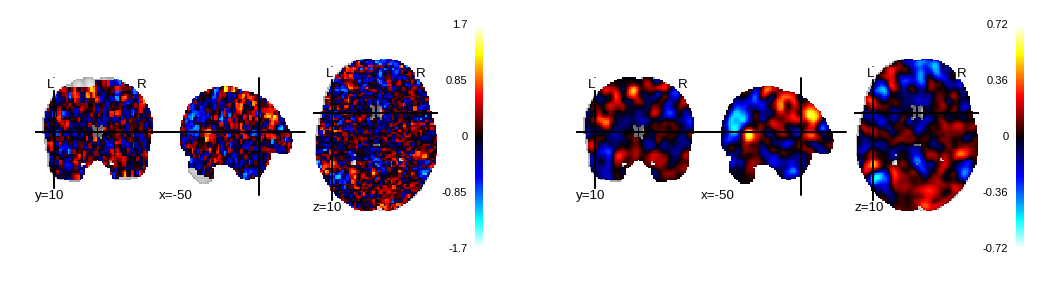

In [47]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
p1 = plotting.plot_stat_map('../train/language_028_fruits.nii.gz',axes=ax1,cut_coords=(-50,10,10))
p2 = plotting.plot_stat_map('../smooIms/s8language_028_fruits.nii.gz',axes=ax2,cut_coords=(-50,10,10))
plt.show()

### make data which are smoothed before averaging, for classical statistics

In [38]:
smooStdMasker = input_data.NiftiMasker(mask_img='../masks/MNI152_T1_2mm_brain_mask.nii.gz',
                                       standardize=True,detrend=True,smoothing_fwhm=8).fit()

In [39]:
bigStatsDf = pd.DataFrame()

for i in range(2):
    
    dataDf,designDf = getData(i+1,smooStdMasker)
    dataDf.drop([0,1,252],inplace=True)
    thisConds = np.array([ np.array([x]*10) for x in designDf['condition'] ]).flatten()
    dataDf.index = [thisConds,dataDf.index]
    
    bigStatsDf = pd.concat([bigStatsDf,dataDf])

In [40]:
bigStatsDf

0         1         2         3         4         5       \
rest     2   -0.695134 -0.454835 -0.895681 -0.221158 -0.065017 -0.528193   
         3   -0.374593 -0.299384 -0.681689 -0.351621 -0.311293 -0.564998   
         4   -0.599094 -0.415662 -0.749298 -0.216665 -0.619677 -0.459878   
         5   -0.083330  0.159697 -0.145437 -0.608196  0.046782 -1.585067   
         6   -1.331327 -1.707782 -1.588579 -1.813464 -1.762218 -1.665666   
         7    0.013412  0.120304 -0.120634  0.514110  0.596066  0.460375   
         8    0.350331  0.028192 -0.162798  0.177324  0.325458  0.004101   
         9   -0.483596 -0.185596  0.095516 -0.466154 -0.285892 -1.447728   
         10  -0.823611 -0.683050 -0.368140 -0.726859 -0.637824 -1.053069   
         11   0.914396  1.783671  1.790192  1.374843  1.703107  1.213915   
language 12  -1.105852 -0.754060 -0.876561 -0.543065 -0.253620 -0.398824   
         13  -0.395820 -0.624676 -0.240171 -0.948132 -1.190030 -1.454828   
         14  -0.798268 -0.502845 -0.611358 -1.327123 -0.524535 -2.558670   
         15  -0.592321 -0.688915 -0.254570 -0.582002 -0.231779 -1.121622   
         16  -1.136863 -0.958555 -1.427391 -0.998004 -0.907088 -1.307216   
         17  -0.850799 -0.662954 -0.542873 -1.312336 -1.199249 -1.063504   
         18  -0.802443 -1.100181 -1.030143 -0.744550 -1.169969 -0.976148   
         19   0.499632  0.728036  0.928614  0.122714  0.229908  0.656739   
         20  -1.068869 -1.424563 -1.462891 -0.523717 -0.470526  0.014499   
         21   1.712230  1.837540  2.064841  1.249991  1.808348  0.858704   
spatial  22  -1.343848 -1.138992 -1.091245 -1.251187 -1.215354 -1.481514   
         23   0.007029  0.210977 -0.157089  0.527438  0.600642 -0.016917   
         24   0.713574  0.949512  1.169125  0.751349  0.835364  0.848839   
         25  -2.074977 -2.325835 -1.746609 -2.079668 -2.015273 -1.224792   
         26   1.200068  0.890324  0.623599  1.259876  1.310840  1.512267   
         27   1.209078  1.466915  1.795791  1.228790  1.349951  0.777968   
         28   0.260609 -0.005805 -0.321475 -0.149987 -0.566904  0.412089   
         29   0.753901  1.064811  0.843720  1.322617  0.975128  1.457026   
         30  -0.035021 -0.245563 -0.518711 -0.075473 -0.434965  0.460630   
         31   1.310435  1.076784  0.925852  1.395768  1.531219  2.222138   
...                ...       ...       ...       ...       ...       ...   
language 222 -0.613288 -0.620898 -0.151957 -0.430443 -0.583337 -0.545981   
         223 -0.355324 -0.460181 -0.764867  0.002684 -0.290433 -0.374633   
         224 -0.317666  0.207568 -0.000016 -0.476535 -0.236338 -0.423322   
         225  0.661106  0.171753 -0.594499 -0.023165 -0.172809  0.089668   
         226 -0.524847 -0.462679 -0.616812 -0.621265 -0.820994 -0.578953   
         227  1.012256  0.960183  0.829103  0.575781  0.851020  0.435982   
         228 -0.090690  0.444418  0.261096 -0.186692  0.074815  0.397277   
         229 -0.145506 -0.722246 -0.287840 -0.716698 -0.956308 -0.168132   
         230 -0.189961 -0.007833  0.605412  0.336577  0.247951  0.320447   
         231 -0.503804  0.075774 -0.088626  0.490016  0.265281  0.985170   
spatial  232  0.604775  0.120898  0.663921 -0.002517 -0.199832 -0.001538   
         233 -0.998353 -0.981945 -1.119486 -0.480002 -0.109549 -0.020432   
         234 -0.049849  0.102154  0.696941  0.466605  0.412747  0.059083   
         235  0.417268  0.516879  0.403720  0.883410  0.754946  0.582747   
         236  0.579327  0.511749 -0.353326  0.421924  0.049870  0.062163   
         237  1.604573  1.409641  1.124500  1.513778  1.404388  1.446545   
         238  0.372708  0.246689  0.448828  0.835446  0.742008  1.211194   
         239  0.449995  0.286953 -0.123243  0.776329  0.643714  1.499387   
         240  0.350107  0.308676  0.722925  1.048219  1.030822  1.445091   
         241  2.526819  2.278278  1.938670  2.406707  2.337162  2.008111   
motor    242  0.547257  0.385691  0.002632  0.851576  0.773823  

In [41]:
from scipy import stats

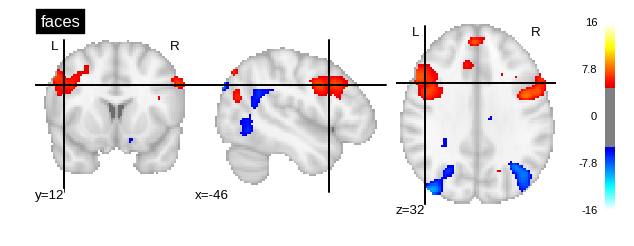

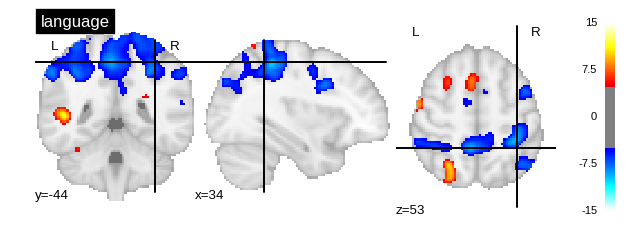

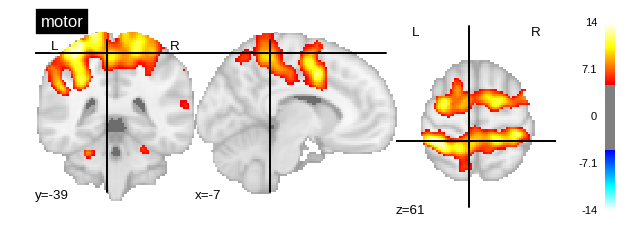

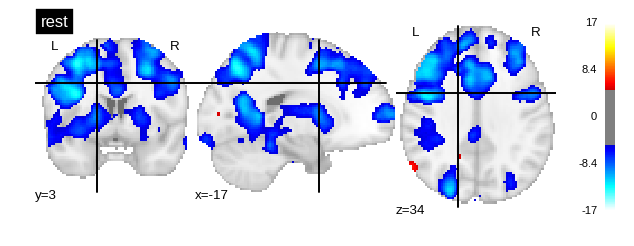

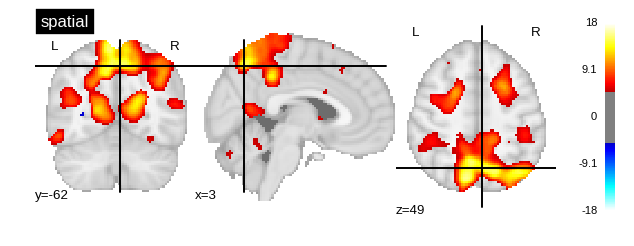

In [42]:
for i in bigStatsDf.index.levels[0]:
    t,p = stats.ttest_ind( bigStatsDf.loc[i],bigStatsDf.drop(i,level=0) )
    im = smooStdMasker.inverse_transform(t)
    plotting.plot_stat_map(im,threshold=5,title=i)
    plt.show()
    im.to_filename('../tMaps/tMap_%s.nii.gz'%i)

In [43]:
tDf = pd.DataFrame([t,p])

In [44]:
tDf = tDf.T
tDf.columns = ['t','p']

In [45]:
tDf[tDf['p']<=0.001].sort_values(by='p',ascending=False).iloc[0]

t    3.310408
p    0.000999
Name: 4103, dtype: float64